<a href="https://colab.research.google.com/github/samsontran/2020-Election-Sentiment-Analysis/blob/main/Election_Tweets_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import csv files
import pandas as pd
sentiment = pd.read_csv('sentiment_analysis.csv')
elections = pd.read_csv('Canadian_elections_2021.csv')

In [20]:
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import Binarizer
from collections import Counter

#classifiers
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import svm

#NLP libraries
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
import html
import cgi
from bs4 import BeautifulSoup

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Part 1: Data Cleaning

Helper functions

In [3]:
#remove all html tags and attributes are remove
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

#replace HTML character codes with an ASCII equivalent
def HTMLEntitiesToUnicode(text):
    """Converts HTML entities to unicode.  For example '&amp;' becomes '&'."""
    soup = BeautifulSoup(text)
    return soup.text

#remove all URLs
def RemoveURL(text):
  import re
  return re.sub(r'http\S+', '', text)

#remove all stop words
def RemoveStopWords(text):
  text_tokens = TweetTokenizer().tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in words]
  filtered_sentence = (" ").join(word for word in tokens_without_sw if (len(word) > 2) or (word == '@'))
  return filtered_sentence

#remove non-alphetical inputs
def RemoveNonAlphabets(text):
  regex = re.compile('[^a-zA-Z @ #]')
  #First parameter is the replacement, second parameter is the input string
  filtered_text = regex.sub('', text)
  return filtered_text

In [4]:
for i in [sentiment,elections]:
  i.text = [remove_html_tags(i.text[x]) for x in range(0,len(i.text))]
  i.text = [HTMLEntitiesToUnicode(i.text[x]) for x in range(0,len(i.text))]
  i.text = [RemoveURL(i.text[x]) for x in range(0,len(i.text))]
  i.text = [i.text[x].lower() for x in range(0,len(i.text))]
  i.text = [RemoveNonAlphabets(i.text[x]) for x in range(0,len(i.text))]

In [5]:
#consider all contractions as stopwords and add it to list 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) #get stop words from the NLTK dictionary

additional_words = ["n't", "'re", "'s","'ll"] #consider all contractions as stop words
words = stop_words.union(additional_words) 

for i in [sentiment,elections]:
  i.text = [RemoveStopWords(i.text[x]) for x in range(0,len(i.text))]

#Part 2: Exploratory Analysis

Design a simple procedure that determines the political party (Liberal, Conservative, 
New Democratic Party (NDP), The People's Party of Canada (PPC)) of a given tweet 
and apply this procedure to all the tweets in the Canadian Elections dataset. A 
suggestion would be to look at relevant words and hashtags in the tweets that identify 
to certain political parties or candidates

In [6]:
elections_clean = elections.copy()
sentiment_clean = sentiment.copy()

#assign tweets to liberal party with the following words
words = ['trudeau', 'liberal', 'justin', '@justintrudeau', '#liberal']
for word in range(0,len(words)):
  actual_word = words[word] 
  elections_clean[actual_word] = elections_clean['text'].str.split().apply(lambda x: x.count(actual_word)) #create new columns for each word in the 'words' list and count the number of times they appear in each tweet
elections_clean['Liberal'] = elections_clean[words].sum(axis=1) #create a new column titled 'Liberal' which sums the total frequency for each Liberal woods column, this is the Liberal's score for each tweet
elections_clean.drop(words,1,inplace=True) #now that we have the 'Liberal' column which sums the total score, we can drop the individual words columns

#Conservative
words = ['conservative', 'otoole', 'toole', '@erinotoole', '#conservative']
for word in range(0,len(words)):
  actual_word = words[word]
  elections_clean[actual_word] = elections_clean['text'].str.split().apply(lambda x: x.count(actual_word))
elections_clean['Conservative'] = elections_clean[words].sum(axis=1)
elections_clean.drop(words,1,inplace=True)

#PPC
words = ['ppc', '#voteppc', '@maximebernier', 'bernier', 'maxime']
for word in range(0,len(words)):
  actual_word = words[word]
  elections_clean[actual_word] = elections_clean['text'].str.split().apply(lambda x: x.count(actual_word))
elections_clean['PPC'] = elections_clean[words].sum(axis=1)
elections_clean.drop(words,1,inplace=True)

#NDP
words = ['ndp', '@thejagmeetsingh', 'jagmeet', 'singh', '#ndp']
for word in range(0,len(words)):
  actual_word = words[word]
  elections_clean[actual_word] = elections_clean['text'].str.split().apply(lambda x: x.count(actual_word))
elections_clean['NDP'] = elections_clean[words].sum(axis=1)
elections_clean.drop(words,1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [7]:
#Assign tweets to the party that they have the highest score with
elections_clean['Party'] = elections_clean.iloc[:,3:7].idxmax(axis="columns")

#if a tweet doesn't have a score for any party, then they are classifed as 'None'
elections_clean.loc[(elections_clean['Liberal'] == 0) & (elections_clean['Conservative'] == 0) &
                    (elections_clean['PPC'] == 0) & (elections_clean['NDP'] == 0),'Party'] = 'None'

#Now that we assigned the tweet to a party, we can drop the party score columns 
elections_clean = elections_clean.drop(elections_clean.columns[[3,4,5,6]], axis=1)
elections_clean['sentiment'] = elections_clean['sentiment'].apply(lambda x: 1 if x =='positive' else 0)

Text(0.5, 1.0, 'Distribution of the Political Afflications of the Tweets')

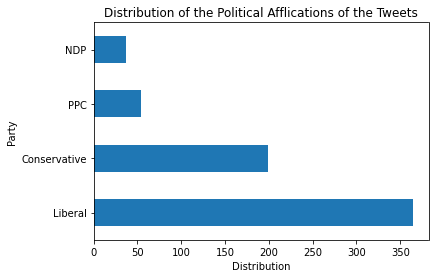

In [8]:
#plot the distribution (I do not show tweets that are part of none because it is not specified in the assignment handout)
elections_clean['Party'].value_counts()[[0,2,3,4]].plot(kind = 'barh')
plt.xlabel('Distribution')
plt.ylabel('Party')
plt.title("Distribution of the Political Afflications of the Tweets")

Most tweets are related to the Liberal party

#Part 3: Model Preparation

In [13]:
sentiment_clean = sentiment.copy()

In [14]:
#remove all usernames and hashtags (ie. strings that start with an '@' or '#')
def RemoveUsernameHashtag(text):
  altered_tweet =  " ".join(filter(lambda x:x[0]!='#' and x[0] !='@', text.split()))
  return altered_tweet

In [15]:
for i in [sentiment_clean,elections_clean]:
  i.text = [RemoveUsernameHashtag(i.text[x]) for x in range(0,len(i.text))]

In [16]:
#lemmatize function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [17]:
#lemmatize all words in the sentiment dataset
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
sentiment_clean['text'] = sentiment_clean.text.apply(lemmatize_text)
sentiment_clean.text = sentiment_clean.text.str.join(" ")

LookupError: ignored

In [21]:
#lemmatize all words in the Canadian Elections dataset
elections_clean['text'] = elections_clean.text.apply(lemmatize_text)
elections_clean.text = elections_clean.text.str.join(" ")

In [22]:
#stemming function
def stemming(text):
  ps = PorterStemmer()
  return [ps.stem(w) for w in w_tokenizer.tokenize(text)]

In [23]:
#stem all words in the sentiment dataset
sentiment_clean['text'] = sentiment_clean.text.apply(stemming)
sentiment_clean.text = sentiment_clean.text.str.join(" ")

In [24]:
#Remove words that only appear once in the sentiment dataset
freq = pd.Series(' '.join(sentiment_clean.text).split()).value_counts()
freq = set(freq[freq ==1].index)

sentiment_clean.text = sentiment_clean.text.apply(lambda x: ' '.join([word for word in x.split() if word not in freq]))

In [25]:
#Remove words that appear only once in the elections dataset
freq = pd.Series(' '.join(elections_clean.text).split()).value_counts()
freq = set(freq[freq ==1].index)

elections_clean.text = elections_clean.text.apply(lambda x: ' '.join([word for word in x.split() if word not in freq]))

Split the generic tweets randomly into training data (70%) and test data (30%).

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    sentiment_clean.drop(labels=['label', 'id'], axis=1),
    sentiment_clean['label'],
    test_size=0.3,
    random_state=0)

In [29]:
#bag of words features
vectorizerBOW = CountVectorizer()
bag_of_words_train = vectorizerBOW.fit_transform(X_train.text.tolist()) #vectorize X_train
bag_of_words_test = vectorizerBOW.transform(X_test.text.tolist()) #vectorize X_test

In [30]:
#Tf-idf features

vectorizerTFIDF = TfidfVectorizer()
tfidf_train = vectorizerTFIDF.fit_transform(X_train.text.tolist()) #vectorize X_train
tfidf_test = vectorizerTFIDF.transform(X_test.text.tolist()) #vectorize X_test

#Part 4a)Model implementation & tuning
Using both types of features (Bag of Words and TF-IDF), train models on the training 
data from generic tweets and apply the model to the test data to obtain an accuracy 
value

###Logistic Regression

Bag of Words

In [ ]:
from sklearn import neighbors

logisticRegr = LogisticRegression(solver='newton-cg') #changed solver to 'newton-cg' because default 'lbfgs' could not converge
logisticRegr.fit(bag_of_words_train, y_train)

predictions = logisticRegr.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using logistic regression and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using logistic regression and Bag of Words is 96.72%


tf-IDF

In [ ]:
logisticRegr = LogisticRegression(solver='newton-cg') #changed solver to 'newton-cg' because default 'lbfgs' could not converge
logisticRegr.fit(tfidf_train, y_train)

predictions = logisticRegr.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using logistic regression and Tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using logistic regression and Tf-IDF is 96.67%


###K-NN

Bag of Words

In [ ]:
model=neighbors.KNeighborsClassifier()
model.fit(bag_of_words_train,y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using K-NN and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using K-NN and Bag of Words is 92.83%


Tf-IDF

In [ ]:
model=neighbors.KNeighborsClassifier()
model.fit(tfidf_train,y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using K-NN and tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using K-NN and tf-IDF is 74.74%


###Naive Bayes

Bag of Words

In [ ]:
model = MultinomialNB()

model.fit(bag_of_words_train,y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Naive Bayes and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using Naive Bayes and Bag of Words is 94.61%


tf-IDF

In [ ]:
model = MultinomialNB()

model.fit(tfidf_train,y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Naive Bayes and tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using Naive Bayes and tf-IDF is 92.58%


###SVM

Bag of Words

In [ ]:
model = svm.LinearSVC(max_iter = 2000) #For large datasets consider using LinearSVC instead (source: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
model.fit(bag_of_words_train, y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using SVM and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using SVM and Bag of Words is 96.55%


tf-IDF

In [ ]:
model = svm.LinearSVC(max_iter = 2000)
model.fit(tfidf_train, y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using SVM and Tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using SVM and Tf-IDF is 96.71%


###Decision Trees

Bag of Words

In [ ]:
model = tree.DecisionTreeClassifier()
model.fit(bag_of_words_train,y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Decision Trees and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using Decision Trees and Bag of Words is 93.4%


tf-IDF

In [ ]:
model = tree.DecisionTreeClassifier()
model.fit(tfidf_train,y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Decision Trees and tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using Decision Trees and tf-IDF is 94.25%


###Random Forest

Bag of Words

In [ ]:
model = RandomForestClassifier()
model.fit(bag_of_words_train,y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Random Forest and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using Random Forest and Bag of Words is 96.07%


tf-IDF

In [ ]:
model = RandomForestClassifier()
model.fit(tfidf_train,y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using Random Forest and Tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using Random Forest and Tf-IDF is 96.14%


###XGBoost

Bag of Words

In [ ]:
from xgboost import XGBClassifier

model=xgb.XGBClassifier()
model.fit(bag_of_words_train,y_train)

predictions = model.predict(bag_of_words_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using XGBoost and Bag of Words is {}%".format(round(accuracy*100,2)))

The accuracy using XGBoost and Bag of Words is 86.42%


tf-IDF

In [ ]:
model=xgb.XGBClassifier()
model.fit(tfidf_train,y_train)

predictions = model.predict(tfidf_test)
accuracy = sklearn.metrics.accuracy_score(y_test, predictions)

print("The accuracy using XGBoost and Tf-IDF is {}%".format(round(accuracy*100,2)))

The accuracy using XGBoost and Tf-IDF is 86.44%


#Part 4a)a.

Q: Evaluate the trained model with the best performance on the Canadian Elections data. How well do your predictions match the sentiment labelled in the Canadian elections data? 

A: Best model is logisitc regression with bag of words features.
(The accuracy using logistic regression and Bag of Words is 96.72%)

In [ ]:
#vectorize Canadian Elections text
bag_of_words_elections = vectorizerBOW.transform(elections_clean.text.tolist())

In [ ]:
model = LogisticRegression(solver='newton-cg')
model.fit(bag_of_words_train, y_train) #Fit the model with the bag of words vectorized matrix from the previous part

predictions = model.predict(bag_of_words_elections)
accuracy = sklearn.metrics.accuracy_score(elections_clean.sentiment, predictions)

print("The accuracy for the Canadian Elections data is {}%".format(round(accuracy*100,2)))

The accuracy for the Canadian Elections data is 68.16%


#Part 4a)c.

Choose the model that has the best performance and visualize the sentiment prediction results and the true sentiment for each of the 4 parties. From this model, discuss your findings and whether NLP analytics based on tweets is 
useful for political parties during election campaigns. Explain how each party 
is viewed in the public eye based on the sentiment value. Suggest one way you 
can improve the accuracy of this model.

In [ ]:
#Split the Canadian Elections dataset into four subsets, based on the four parties
conservative, liberal, ndp, none, ppc = [x for _, x in elections_clean.groupby(elections_clean['Party'])]

In [ ]:
#Vectorize the four subsets
bag_of_words_conservative = vectorizerBOW.transform(conservative.text.tolist())
bag_of_words_liberal = vectorizerBOW.transform(liberal.text.tolist())
bag_of_words_ndp = vectorizerBOW.transform(ndp.text.tolist())
bag_of_words_ppc = vectorizerBOW.transform(ppc.text.tolist())

In [ ]:
#generate predictions for each subset
predictions_conservative = model.predict(bag_of_words_conservative)
predictions_liberal = model.predict(bag_of_words_liberal)
predictions_ndp = model.predict(bag_of_words_ndp)
predictions_ppc = model.predict(bag_of_words_ppc)

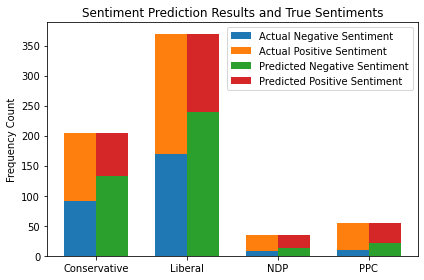

In [ ]:
labels = ['Conservative', 'Liberal', 'NDP', 'PPC']

#count the number of predicted negative and positive tweets for the four parties
negative_count_predicted = [Counter(predictions_conservative)[0], Counter(predictions_liberal)[0]
                  , Counter(predictions_ndp)[0], Counter(predictions_ppc)[0]]
positive_count_predicted = [Counter(predictions_conservative)[1], Counter(predictions_liberal)[1]
                  , Counter(predictions_ndp)[1], Counter(predictions_ppc)[1]]

#count the number of actual negative and positive tweets for the four parties
negative_count_actual = [conservative.sentiment.value_counts()[0], liberal.sentiment.value_counts()[0]
                  , ndp.sentiment.value_counts()[0], ppc.sentiment.value_counts()[0]]
positive_count_actual = [conservative.sentiment.value_counts()[1], liberal.sentiment.value_counts()[1]
                  , ndp.sentiment.value_counts()[1], ppc.sentiment.value_counts()[1]]

#create a stacked, grouped bar chart
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, negative_count_actual, width, label = 'Actual Negative Sentiment')
rects2 = ax.bar(x - width/2, positive_count_actual, width, bottom=negative_count_actual, label = 'Actual Positive Sentiment')

rects3 = ax.bar(x + width/2, negative_count_predicted, width, label = 'Predicted Negative Sentiment')
rects4 = ax.bar(x + width/2, positive_count_predicted, width, bottom=negative_count_predicted, label = 'Predicted Positive Sentiment')

ax.set_ylabel('Frequency Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Sentiment Prediction Results and True Sentiments')
ax.legend()

fig.tight_layout()

plt.show()

#Part 4b)

Split the negative Canadian elections tweets into training data (70%) and test data (30%). Use the true sentiment labels in the Canadian elections data instead of your predictions from the previous part. 

In [ ]:
elections_negative, elections_positive = [x for _, x in elections_clean.groupby(elections_clean['sentiment'])]

In [ ]:
#Convert categorical negative reasons into numerical values
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

elections_negative['negative_reason_cat'] = labelencoder.fit_transform(elections_negative['negative_reason'])

In [ ]:
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(
    elections_negative.drop(labels=['negative_reason_cat', 'sentiment', 'negative_reason', 'Party', 'text length'], axis=1),
    elections_negative['negative_reason_cat'],
    test_size=0.3,
    random_state=0)

Vectorize dataset with bag of words features for the X_train and X_test datasets

In [ ]:
#bag of words
bag_of_words_train_neg = vectorizerBOW.fit_transform(X_train_neg.text.tolist()) #vectorize X_train
bag_of_words_test_neg = vectorizerBOW.transform(X_test_neg.text.tolist()) #vectorize X_test

Tune the hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV

#use gridsearch to find the optimal 'C' and 'solver' hyperparameters
grid = {'C': [0.001,0.01,0.05,0.1,0.5,1,5,10, 100], 'solver': ['newton-cg','saga','sag','lbfgs']}
model = LogisticRegression(multi_class='multinomial', max_iter = 10000)
model_cv = GridSearchCV(model, grid, cv=2, scoring='accuracy')
model_cv.fit(bag_of_words_train_neg, y_train_neg)

print("Best hyperparameters:", model_cv.best_params_)
print("Best accuracy: {}%".format((round(model_cv.best_score_*100,2))))

Best hyperparameters: {'C': 0.5, 'solver': 'newton-cg'}
Best accuracy: 48.52%


In [ ]:
#use the best model to predict the reasonings for the test subset
model = LogisticRegression(multi_class='multinomial', C = 0.5, solver = 'newton-cg', max_iter = 10000)
model.fit(bag_of_words_train_neg, y_train_neg)
predictions = model.predict(bag_of_words_test_neg)

In [ ]:
#revert the numerical values back into their categorical reasonings
inverted_predictions = labelencoder.inverse_transform(predictions) #do this for the predictions
inverted_y_test_neg = labelencoder.inverse_transform(y_test_neg) #do this for the actual y-values in the test set too

In [ ]:
#get the test results into a dataframe to compare the actual and predicted reasonings
X_test_neg['Actual Reasoning'] =  inverted_y_test_neg
X_test_neg['Predicted Reasoning'] = inverted_predictions

#Part 4c) 
Use the frequency of the words (Bag of Words) for (i) positive and (ii) negative tweets using the ground truth sentiment to rank the top-50 most frequent non-stop-words in the Canadian elections dataset

(i) positive tweets

In [ ]:
import itertools
positive_words = elections_positive.text.apply(lambda x: TweetTokenizer().tokenize(x)) #tokenize the words in the elections dataset with negative sentiment
positive_words = list(itertools.chain(*positive_words)) #combine all the lists into one
positive_words_frequency = Counter(positive_words) #count the frequency of each word
[word for word,cnt in positive_words_frequency.most_common(50)] #compile the top 50 words into a list

['election',
 'canadian',
 'vote',
 'trudeau',
 'canada',
 'otoole',
 'party',
 'good',
 'win',
 'get',
 'liberal',
 'federal',
 'conservative',
 'like',
 'freedom',
 'day',
 'want',
 'need',
 'leader',
 'best',
 'people',
 'right',
 'support',
 'would',
 'time',
 'better',
 'great',
 'voting',
 'hope',
 'let',
 'justin',
 'love',
 'ppc',
 'make',
 'think',
 'one',
 'ndp',
 'voted',
 'please',
 'care',
 'choice',
 'debate',
 'going',
 'government',
 'cpc',
 'country',
 'pandemic',
 'know',
 'year',
 'back']

Create a word cloud

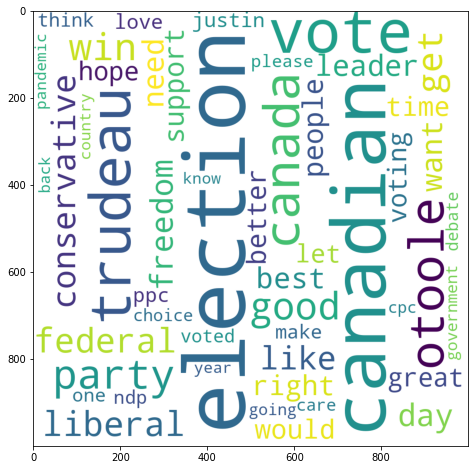

In [ ]:
positive_words_frequency.most_common(50)

from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict(positive_words_frequency.most_common(50)))
plt.figure(figsize=(15,8))
plt.imshow(wc)

(ii) negative tweets

In [ ]:
negative_words = elections_negative.text.apply(lambda x: TweetTokenizer().tokenize(x))
negative_words = list(itertools.chain(*negative_words))
negative_words_frequency = Counter(negative_words)
[word for word,cnt in negative_words_frequency.most_common(50)]

['election',
 'canadian',
 'trudeau',
 'otoole',
 'canada',
 'pandemic',
 'vote',
 'like',
 'conservative',
 'liberal',
 'year',
 'party',
 'gun',
 'want',
 'called',
 'say',
 'people',
 'care',
 'leader',
 'one',
 'get',
 'think',
 'never',
 'justin',
 'call',
 'would',
 'calling',
 'million',
 'country',
 'erin',
 'day',
 'win',
 'many',
 'good',
 'government',
 'time',
 'know',
 'going',
 'lie',
 'con',
 'covid',
 'unnecessary',
 'bad',
 'plan',
 'way',
 'right',
 'see',
 'look',
 'federal',
 'take']

generate word cloud

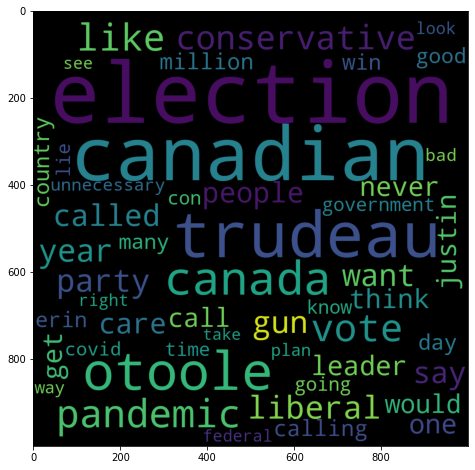

In [ ]:
wc = WordCloud(background_color="black",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(dict(negative_words_frequency.most_common(50)))
plt.figure(figsize=(15,8))
plt.imshow(wc)